## Setup

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import torch
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import applications
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Convolution2D, MaxPool2D, Flatten
from keras.models import Model
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.utils import compute_class_weight
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers import LeakyReLU, PReLU
from keras.layers import add
from keras.applications.vgg19 import VGG19
import torch.optim as optim
import torch.nn.functional as F


#Make sure we are running on the
print(torch.cuda.is_available())
# Storing ID of current CUDA device
if torch.cuda.is_available():
  cuda_id = torch.cuda.current_device()
  print(torch.cuda.get_device_name(cuda_id))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
NVIDIA A100-SXM4-40GB
cuda


## DataGeneraotr

In [30]:
#create custom data generator which inherts from tf.keras.utils.Sequence
#args of the data generator are list of image paths, list of asscoiated labels, batch size, and shuffle
#outout is a tensor of tensors holding a batch of low resoltuion images, 
#a tensor of tensors holding a batch of high resoltuion images, 
#and a list of labels associated
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, x_in, y_in, batch_size, shuffle):
        #initialize variables
        self.x = x_in
        self.y = y_in
        self.batch_size = batch_size
        self.datalen = len(y_in)
        self.indexes = np.arange(self.datalen)
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.indexes)
        

    def __len__(self):
        return self.datalen // self.batch_size

    def __getitem__(self, idx):
        #create batch of image paths and their labels
        batch_x = self.x[idx*self.batch_size : (idx + 1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size : (idx + 1)*self.batch_size]
        #initialize empty array to hold tensor of images
        low_res_images = []
        high_res_images = []

        #Loop through batch of image paths
        for path_sample in batch_x:
           #grab image from path, set size to 128x128
            img = tf.keras.preprocessing.image.load_img(path_sample, target_size=(128,128))
            #convert image to tensor
            high_res = tf.image.convert_image_dtype(img, tf.float32)
            #resize high resolution image to 32x32 to create low resolution image
            low_res = tf.image.resize(high_res, [32, 32])
            #add images to arrays
            low_res_images.append(low_res)
            high_res_images.append(high_res)
        
        #convert array of image tensors to a tensor of tensors
        low_res_images = tf.stack(low_res_images)
        high_res_images = tf.stack(high_res_images)
        return low_res_images, high_res_images, batch_y

# Import Data

In [31]:
#!unzip '/content/drive/MyDrive/Biomedical AI/Data.zip' > /dev/null

In [32]:
#define directories
train_dir = '/content/Data/train'
test_dir = '/content/Data/test'
#define class names
classes = ['DME', 'DRUSEN']

# create lists to store the file paths and labels
train_files = []
train_labels = []
test_files = []
test_labels = []

# loop through the two classes to get the file paths and labels for train, val and test sets
for class_name in classes:
    train_class_dir = os.path.join(train_dir, class_name)
    for file in os.listdir(train_class_dir):
        train_files.append(os.path.join(train_class_dir, file))
        train_labels.append(class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    for file in os.listdir(test_class_dir):
        test_files.append(os.path.join(test_class_dir, file))
        test_labels.append(class_name)

# convert the labels to numerical values
label_map = {'DME': 0, 'DRUSEN': 1}
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

In [33]:
#This block is used to shuffle the lists created above
import random

# Combine the lists into a list of tuples
combined1 = list(zip(train_files, train_labels))
combined2 = list(zip(test_files, test_labels))

# Shuffle the list of tuples
random.shuffle(combined1)
random.shuffle(combined2)

# Separate the shuffled list of tuples back into two lists
train_files, train_labels = zip(*combined1)
test_files, test_labels = zip(*combined2)

In [34]:
train_num = len(train_files)
test_num = len(test_files)

#convert labels to multilabel using one-hot encoding
num_classes = 2
train_labels = tf.one_hot(train_labels, num_classes)
test_labels = tf.one_hot(test_labels, num_classes)

In [35]:
#create generators using custom class for training, validation, and testing
train_gen = DataGenerator(train_files, train_labels, batch_size = 30, shuffle=True)
test_gen = DataGenerator(test_files, test_labels, batch_size = 30, shuffle=True)

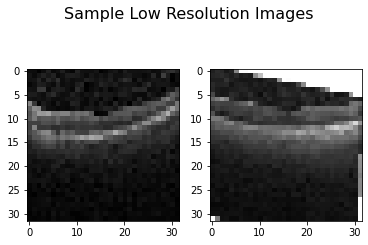

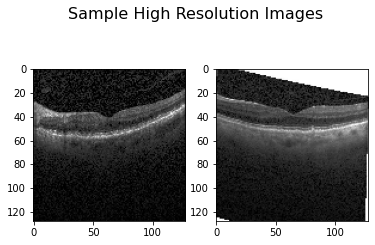

y Labels:  tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


In [36]:
#visualize the augmented data
# Get the next batch of images from the train generator
train_low_res_images, train_high_res_images, train_labels = train_gen.__getitem__(0)

#grab the first 8 in the batch and their labels and plot them
for k in range(1,3):
    sample_lr_img = train_low_res_images[k,:,:,:]
    plt.subplot(1, 2, k)
    plt.imshow(sample_lr_img)
plt.suptitle('Sample Low Resolution Images', fontsize = 16)    
plt.show()

for k in range(1,3):
    sample_hr_img = train_high_res_images[k,:,:,:]
    plt.subplot(1, 2, k)
    plt.imshow(sample_hr_img)
plt.suptitle('Sample High Resolution Images', fontsize = 16)    
plt.show()

print('y Labels: ', train_labels[1:3])

## build SRGAN Functions and Classes

In [37]:
# Residual block
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model

In [38]:
def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [39]:
def up_sampling_block(model, kernal_size, filters, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model 

In [42]:
class Generator(object):

    def __init__(self, noise_shape):
        self.noise_shape = noise_shape
        
    def generator(self):
        gen_input = Input(shape = self.noise_shape)
			
        model = Conv2D(filters=64, kernel_size=9, strides=1, padding="same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
				
        gen_model = model

        # Using 16 Residual Blocks
        for index in range(16):
            model = res_block_gen(model, 3, 64, 1)
        
        model = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(model)
        model = BatchNormalization(momentum=0.5)(model)
        model = add([gen_model, model])
        
        # Using 2 UpSampling Blocks
        for index in range(2):
            model = up_sampling_block(model, 3, 256, 1)
        
        model = Conv2D(filters=3, kernel_size=9, strides=1, padding="same")(model)
        model = Activation('tanh')(model)
       
        generator_model = Model(inputs=gen_input, outputs=model)
        
        return generator_model

In [43]:
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        
        return discriminator_model

In [44]:
#combines discriminator and generator to be one model
def get_SRgan_network(discriminator, shape, generator, optimizer, vgg_loss):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

## Define Losses

In [45]:
class VGGLoss(tf.keras.Model):
    def __init__(self, feature_layer=36):
        super(VGGLoss, self).__init__()
        self.vgg = VGG19(include_top=False, input_shape=(None, None, 3))
        self.vgg.trainable = False
        self.feature_layer = feature_layer
        self.loss = tf.keras.losses.MeanSquaredError()

    def call(self, x, y):
        # Use the VGG feature extractor to compute features
        x_features = self.vgg(x)
        y_features = self.vgg(y)

        # Compute the feature difference between the generated and target images
        x_features = tf.stop_gradient(x_features)
        y_features = tf.stop_gradient(y_features)
        loss = self.loss(x_features, y_features)

        return loss

In [46]:
import tensorflow.keras.backend as K

def dis_loss_fn(real_pred, fake_pred):
    real_loss = K.binary_crossentropy(tf.ones_like(real_pred), real_pred)
    fake_loss = K.binary_crossentropy(tf.zeros_like(fake_pred), fake_pred)
    d_loss = real_loss + fake_loss
    return d_loss

## Define Training Loop

In [66]:
from PIL import Image
import os
from contextlib import redirect_stdout
import sys
from tqdm import tqdm
original_stdout = sys.stdout

def train(epochs, batch_size, output_dir, model_save_dir, generator, discriminator, train_dataloader, val_dataloader, generator_optimizer, discriminator_optimizer, generator_loss_fn, discriminator_loss_fn):
     
    loss = VGGLoss(image_shape)

    for e in range(epochs):
      train_bar_desc = f"Epoch {e+1} Training"
      running_train_generator_loss = 0.0
      running_train_discriminator_loss = 0.0
      running_val_generator_loss = 0.0
      running_val_discriminator_loss = 0.0

      for batch_idx, (low_res_images, high_res_images, labels) in enumerate(tqdm(train_dataloader, desc=train_bar_desc)):         
            generator.trainable = True
            #generate prediction
            generated_images_sr = generator.predict(low_res_images)
            
            #compute discriminator Loss
            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_data_Y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            sys.stdout = open(os.devnull, 'w')
            d_loss_real = discriminator.train_on_batch(high_res_images, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            sys.stdout = original_stdout
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

            #gen loss
            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2

            discriminator.trainable = False

            sys.stdout = open(os.devnull, 'w')
            gan_loss = gan.train_on_batch(low_res_images, [high_res_images,gan_Y])
            sys.stdout = original_stdout

            running_train_generator_loss += sum(gan_loss)
            #running_train_discriminator_loss += sum(discriminator_loss.numpy())
            running_train_discriminator_loss += discriminator_loss

      # for batch_idx, (low_res_images, high_res_images, labels) in enumerate(val_dataloader):
      #     # Compute generator and discriminator loss
      #     generated_images = generator(low_res_images)

      #     real_scores = discriminator(high_res_images, training=False)
      #     fake_scores = discriminator(generated_images, training=False)

      #     discriminator_loss = discriminator_loss_fn(real_scores, fake_scores)

      #     #gen loss
      #     gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2

      #     sys.stdout = open(os.devnull, 'w')
      #     gan_loss = gan.train_on_batch(low_res_images, [high_res_images,gan_Y])
      #     sys.stdout = original_stdout

      #     # Keep track of validation losses and accuracy
      #     running_val_generator_loss += sum(gan_loss)
      #     running_val_discriminator_loss += sum(discriminator_loss.numpy())

      train_generator_loss = running_train_generator_loss / len(train_dataloader)
      train_discriminator_loss = running_train_discriminator_loss / len(train_dataloader)
      #val_generator_loss = running_val_generator_loss / len(val_dataloader)
      #val_discriminator_loss = running_val_discriminator_loss / len(val_dataloader)
      # Print losses and accuracy for this epoch

      #print(f"Epoch {e+1}: Train Gen Loss: {str(train_generator_loss)}, Train Disc Loss: {str(train_discriminator_loss)}, Val Gen Loss: {str(val_generator_loss)}, Val Disc Loss: {str(val_discriminator_loss)}")
      print(f"Epoch {e+1}: Train Gen Loss: {str(train_generator_loss)}, Train Disc Loss: {str(train_discriminator_loss)}")

      if e % 10 == 0:
          generator.save(model_save_dir + 'gen_model%d.h5' % e)
          # Get a random low-res image from the validation dataset
          idx = np.random.randint(len(val_dataloader))
          low_res_image, high_res_image, _ = val_dataloader[idx]
          low_res_image = low_res_image[0]
          high_res_image = high_res_image[0]

          # Generate a high-res image from the low-res input
          generated_image = generator.predict(np.expand_dims(low_res_image, axis=0))[0]

          # Create a figure with three subplots
          fig, axs = plt.subplots(1, 3, figsize=(10, 5))

          # Show the low-res image in the first subplot
          axs[0].imshow(low_res_image)
          axs[0].set_title(f"Resolution: {low_res_image.shape[0]}x{low_res_image.shape[1]}")

          # Show the high-res image in the second subplot
          axs[1].imshow(high_res_image)
          axs[1].set_title(f"Resolution: {high_res_image.shape[0]}x{high_res_image.shape[1]}")

          # Show the generated image in the third subplot
          axs[2].imshow(generated_image)
          axs[2].set_title(f"Resolution: {generated_image.shape[0]}x{generated_image.shape[1]}")

          plt.show()

          # Save the figure to a file
          #plt.savefig(os.path.join(output_dir, f'epoch{e}_sample{e}.png'))

## Training!

In [67]:
epochs = 50

batch_size = 30
shape = (32,32,3)
image_shape = (128,128,3)

gen_loss_fn = VGGLoss(image_shape)

generator = Generator(shape).generator()
discriminator = Discriminator(image_shape).discriminator()

# Define the optimizer
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

generator.compile(loss=gen_loss_fn.call, optimizer=gen_optimizer)
discriminator.compile(loss="binary_crossentropy", optimizer=disc_optimizer)

gan = get_SRgan_network(discriminator, shape, generator, gen_optimizer, gen_loss_fn.call)


output_dir = '/content/drive/MyDrive/Biomedical AI/srImages'
model_save_dir = '/content/drive/MyDrive/Biomedical AI/midtermModels'

Epoch 1 Training: 100%|██████████| 637/637 [04:10<00:00,  2.54it/s]


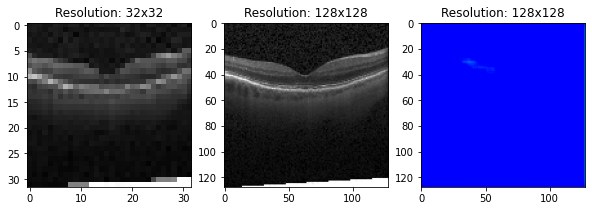

Epoch 11 Training: 100%|██████████| 637/637 [03:39<00:00,  2.90it/s]


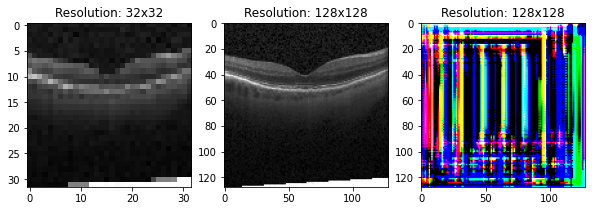

Epoch 21 Training: 100%|██████████| 637/637 [03:39<00:00,  2.91it/s]


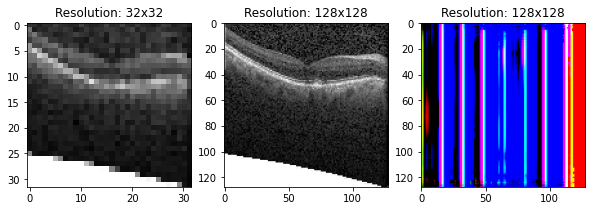

Epoch 31 Training: 100%|██████████| 637/637 [03:41<00:00,  2.88it/s]


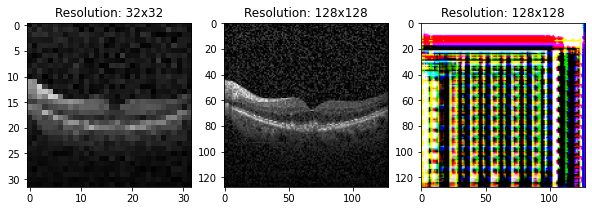

Epoch 41 Training: 100%|██████████| 637/637 [03:40<00:00,  2.89it/s]


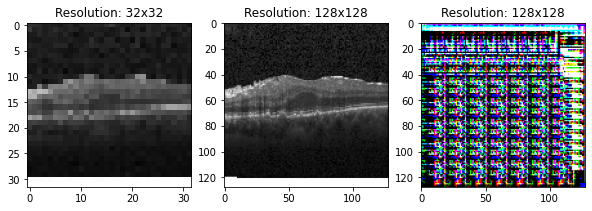

Epoch 50 Training: 100%|██████████| 637/637 [03:41<00:00,  2.88it/s]


In [68]:
#train(generator, discriminator, train_gen, test_gen, gen_loss_fn, dis_loss_fn, optimizer, optimizer, epochs)
#train(epochs, batch_size, output_dir, model_save_dir, generator, discriminator, train_gen, test_gen, gen_loss_fn, dis_loss_fn)
train(epochs, batch_size, output_dir, model_save_dir, generator, discriminator, train_gen, test_gen, gen_optimizer, disc_optimizer, gen_loss_fn, dis_loss_fn)